In [85]:
from utils import *
from pandas import wma
import time
import numpy as np
import pandas as pd
from pandas import read_csv
from numpy import array
from numpy import newaxis
import math
from scipy import stats
from subprocess import check_output
import datetime
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

ImportError: cannot import name 'wma'

Analysis on CEM Gasoline Futures

In [25]:
def parser(x):
     return datetime.datetime.strptime(x, '%m/%d/%Y')
 
data = pd.read_csv('big_df_adj.csv', header=0, parse_dates=['CME_RB1_FWd'], date_parser=parser,  low_memory=False)


In [17]:
mx.random.seed(1719)
context = mx.cpu(); model_ctx=mx.cpu()


In [124]:
df = data[['CME_RB1_FWd', 'CME_RB1_FWs']]

In [28]:
df.dtypes

CME_RB1_FWd    datetime64[ns]
CME_RB1_FWs           float64
dtype: object

In [62]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset.rolling(7).mean()
    dataset['ma21'] = dataset.rolling(21).mean()

    # Create MACD
    dataset['26ema'] = pd.ewma(dataset, span=26)
    dataset['12ema'] = pd.ewma(dataset, span=12)
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
# Create Bollinger Bands
    dataset['20sd'] = pd.stats.moments.rolling_std(dataset['price'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    
    return dataset

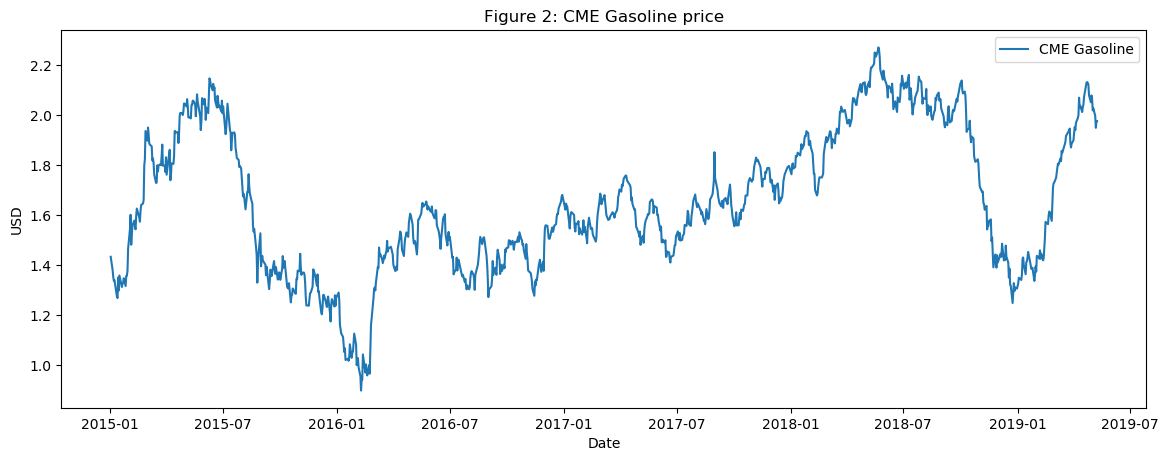

In [39]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df['CME_RB1_FWd'], df['CME_RB1_FWs'], label='CME Gasoline')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: CME Gasoline price')
plt.legend()
plt.show()

In [44]:
num_training_days = int(df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, df.shape[0]-num_training_days))

Number of training days: 767. Number of test days: 329.


In [116]:
data_TI = df[["CME_RB1_FWs"]]


In [118]:
data_TI['ma7'] = df[["CME_RB1_FWs"]].rolling(7).mean()
data_TI['ma21'] = df[["CME_RB1_FWs"]].rolling(21).mean()

#     # Create MACD

#     dataset['12ema'] = pd.ewma(dataset, span=12)
#     dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
# # Create Bollinger Bands
#     dataset['20sd'] = pd.stats.moments.rolling_std(dataset['price'],20)
#     dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
#     dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
#     # Create Exponential moving average
#     dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
#     # Create Momentum
#     dataset['momentum'] = dataset['price']-1

EWM [com=12.5,min_periods=0,adjust=True,ignore_na=False,axis=0]

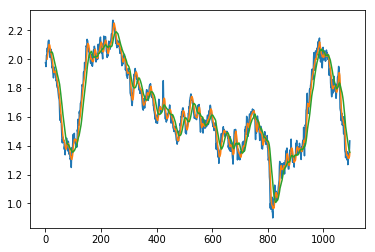

In [120]:
plt.plot(data_TI)

In [153]:
dataset = pd.read_csv('big_df_adj.csv', header=0, keep_default_na=False, parse_dates=[0], date_parser=parser,  low_memory=False)
df_z = np.abs(stats.zscore(df['CME_RB1_FWs']))
threshhold = 3
print(np.where(df_z>threshhold))
dataset_ex_df = df[(df_z < threshhold)]

(array([], dtype=int64),)


In [125]:
df

,CME_RB1_FWd,CME_RB1_FWs
0,2019-05-09,1.97540
1,2019-05-08,1.97500
2,2019-05-07,1.94870
3,2019-05-06,1.99660
4,2019-05-03,2.02650
5,2019-05-02,2.01830
6,2019-05-01,2.06420
7,2019-04-30,2.07808
8,2019-04-29,2.05076
9,2019-04-26,2.07888


In [121]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 4 columns):
CME_RB1_FWd    1096 non-null datetime64[ns]
CME_RB1_FWs    1096 non-null float64
ma7            1090 non-null float64
ma21           1076 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 34.3 KB


In [122]:
data_FT = df
close_fft = np.fft.fft(np.asarray(data_FT['CME_RB1_FWs'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['CME_RB1_FWs'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: CME Gasoline  & Fourier transforms')
plt.legend()
plt.show()

ValueError: setting an array element with a sequence.

ARIMA - Test MSE: 49.587
                    ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.CME_SES   No. Observations:                 1077
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3423.963
Method:                       css-mle   S.D. of innovations              5.814
Date:                Sat, 11 May 2019   AIC                           6861.925
Time:                        17:39:35   BIC                           6896.799
Sample:                             1   HQIC                          6875.132
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0669      0.191     -0.351      0.726      -0.440       0.307
ar.L1.D.CME_SES     0.0239      0.030      0.786      0.432      -0.036       0.084
ar.L2.D.CME_SES     0.0063      0.030      0.206      0.837      -0.053       0.066
ar.L3.D.CME_SES    -0.0023      0.030     -0.074      0.941      -0.062       0.057
ar.L4.D.CME_SES     0.0139      0.030      0.458      0.647      -0.046       0.074
ar.L5.D.CME_SES     0.0287      0.032      0.901      0.368      -0.034       0.091
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9237           -0.0000j            1.9237           -0.0000
AR.2            0.5623           -1.9161j            1.9969           -0.2046
AR.3            0.5623           +1.9161j            1.9969            0.2046
AR.4           -1.7669           -1.1919j            2.1313           -0.4055
AR.5           -1.7669           +1.1919j            2.1313            0.4055
-----------------------------------------------------------------------------

In [120]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(X_train_FI,y_train_FI, eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], verbose=False)
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

NameError: name 'xgb' is not defined